In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Mon Jan 22 02:59:23 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   50C    P0    72W / 300W |  27899MiB / 80994MiB |     41%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -2
hp.const_sigma = True
hp.quantize = False
hp.prior_mu = 0.999

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_0.999_-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

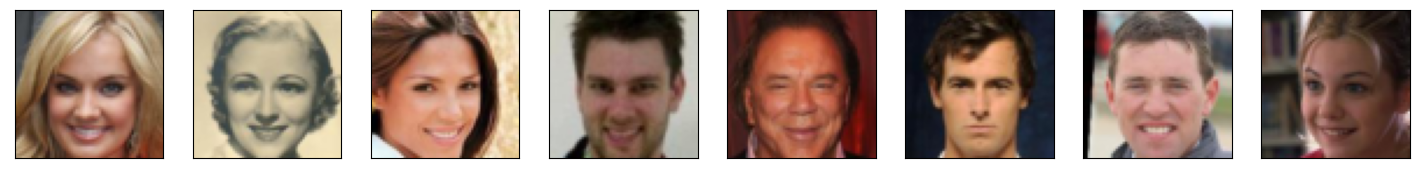

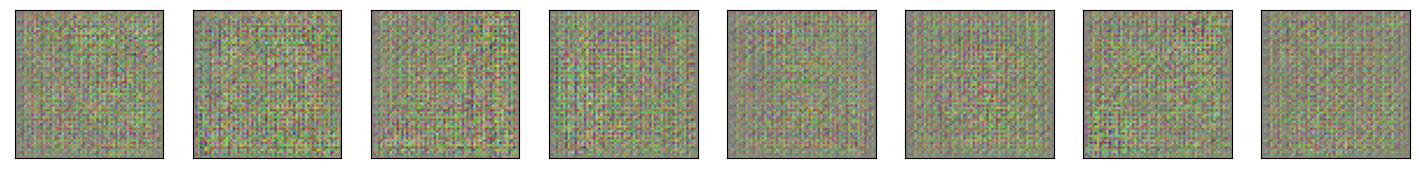

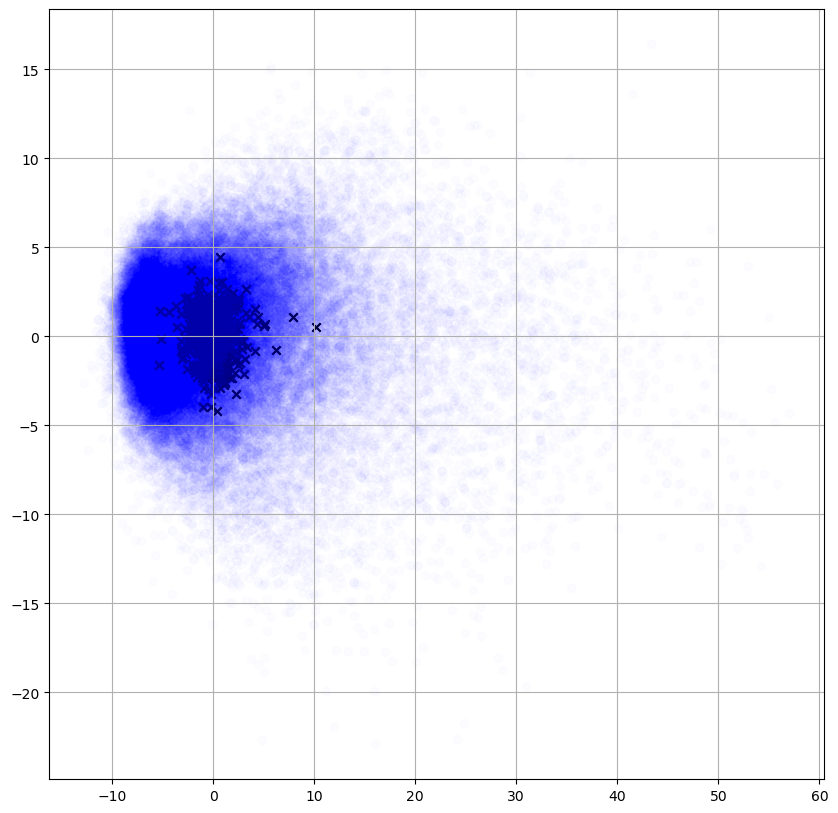

1
lse_loss 2761.061767578125
commit_loss 4.959683895111084
recon_loss 0.10165704786777496
2
lse_loss 2468.258056640625
commit_loss 4.61083984375
recon_loss 0.09699200093746185
3
lse_loss 2277.4619140625
commit_loss 4.404496192932129
recon_loss 0.0947677493095398
4
lse_loss 2072.58349609375
commit_loss 4.3008646965026855
recon_loss 0.09570275247097015
5
lse_loss 1869.577392578125
commit_loss 4.203708648681641
recon_loss 0.0919218584895134
6
lse_loss 1707.5733642578125
commit_loss 4.073218822479248
recon_loss 0.0882236585021019
7
lse_loss 1611.82568359375
commit_loss 3.9769625663757324
recon_loss 0.08887654542922974
8
lse_loss 1539.016845703125
commit_loss 3.9069056510925293
recon_loss 0.0857856497168541
9
lse_loss 1470.781982421875
commit_loss 3.87188982963562
recon_loss 0.08041857182979584
10
lse_loss 1416.078369140625
commit_loss 3.724977970123291
recon_loss 0.08148081600666046
11
lse_loss 1380.944580078125
commit_loss 3.7024824619293213
recon_loss 0.07844734191894531
12
lse_loss 1337

92
lse_loss 944.52587890625
commit_loss 2.199174165725708
recon_loss 0.028998464345932007
93
lse_loss 943.5677490234375
commit_loss 2.20381498336792
recon_loss 0.02910318598151207
94
lse_loss 938.3438720703125
commit_loss 2.1921133995056152
recon_loss 0.03060154616832733
95
lse_loss 945.010498046875
commit_loss 2.2497448921203613
recon_loss 0.028755439445376396
96
lse_loss 932.5452880859375
commit_loss 2.1614625453948975
recon_loss 0.029789473861455917
97
lse_loss 939.0548095703125
commit_loss 2.1751832962036133
recon_loss 0.02912110462784767
98
lse_loss 930.826171875
commit_loss 2.227841377258301
recon_loss 0.027414735406637192
99
lse_loss 925.223876953125
commit_loss 2.1612584590911865
recon_loss 0.027008630335330963
100
lse_loss 934.25048828125
commit_loss 2.150956153869629
recon_loss 0.02762272022664547
101
lse_loss 927.115234375
commit_loss 2.1454179286956787
recon_loss 0.0279860757291317
102
lse_loss 930.730224609375
commit_loss 2.1892147064208984
recon_loss 0.026781167834997177


182
lse_loss 820.197998046875
commit_loss 1.8398511409759521
recon_loss 0.016769185662269592
183
lse_loss 821.5665283203125
commit_loss 1.808924674987793
recon_loss 0.01690709963440895
184
lse_loss 812.2601318359375
commit_loss 1.7651628255844116
recon_loss 0.015406021848320961
185
lse_loss 819.7306518554688
commit_loss 1.8094730377197266
recon_loss 0.016688544303178787
186
lse_loss 807.4201049804688
commit_loss 1.7719910144805908
recon_loss 0.01597798988223076
187
lse_loss 819.9282836914062
commit_loss 1.8177740573883057
recon_loss 0.015836071223020554
188
lse_loss 814.4662475585938
commit_loss 1.796457290649414
recon_loss 0.016418475657701492
189
lse_loss 812.5654907226562
commit_loss 1.7318576574325562
recon_loss 0.016993848606944084
190
lse_loss 811.777587890625
commit_loss 1.774505376815796
recon_loss 0.01557131391018629
191
lse_loss 809.0789794921875
commit_loss 1.7537020444869995
recon_loss 0.016140166670084
192
lse_loss 811.998046875
commit_loss 1.7881526947021484
recon_loss 0.

271
lse_loss 756.1854248046875
commit_loss 1.5160527229309082
recon_loss 0.011587422341108322
272
lse_loss 743.2486572265625
commit_loss 1.5452263355255127
recon_loss 0.01163172535598278


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')